# <center> <img src="figs/LogoUFSCar.jpg" alt="Logo UFScar" width="110" align="left"/>  <br/> <center>Universidade Federal de São Carlos (UFSCar)<br/><font size="4"> Departamento de Computação, campus Sorocaba</center></font>
</p>

<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
  
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>

## <center>Projeto Final</center>

**Nome**: Paula Caires Silva

**RA**: 792230


---
## Análise exploratória

Nesta seção, deve ser feita a leitura da base de dados e todas as análises necessárias para interpretar e analisar os dados, tais como:
* Significado de cada atributo
* Medidas descritivas
* Gráficos

In [1]:
# Caminho dos arquivos
FILES_DIRECTORY = "dados"

import numpy as np
import pandas as pd 
import os

# Importa o arquivo e guarda em um dataframe do Pandas
df_original = pd.read_csv( os.path.join(FILES_DIRECTORY, 'RHP_data.csv'), sep=',', index_col=None)
df = pd.read_csv( os.path.join(FILES_DIRECTORY, 'RHP_data.csv'), sep=',', index_col=None)

# Importa o arquivo de teste (final) e guarda em um dataframe do Pandas
df_test = pd.read_csv( os.path.join(FILES_DIRECTORY, 'test.csv'), sep=',', index_col=None)

# Importa o arquivo de classes e guarda em um dataframe do Pandas
df_classe = pd.read_csv( os.path.join(FILES_DIRECTORY, 'train.csv'), sep=',', index_col=None)

display('Dimensão do dataframe com as informações:', df.shape[0])
display('Dimensão do dataframe de teste:', df_test.shape[0])
display('Dimensão do dataframe de classes:', df_classe.shape[0])

print('Dados carregados com sucesso!')

'Dimensão do dataframe com as informações:'

17873

'Dimensão do dataframe de teste:'

3146

'Dimensão do dataframe de classes:'

14727

Dados carregados com sucesso!


---
## Análise Exploratória de Dados (EDA)

Primeiro, utilizando-se dos recursos da estatística descritiva, será feita a caracterização dos dados para conhecer a distribuição deles e características em busca de padrões ou tendências, bem como quais são os problemas que serão endereçados na etapa de pré-processamento dos dados, como a presença de outliers. Conhecer essas informações permite uma modelagem e tratamento de dados alinhada com a natureza deles.

Depois, fazer a escala dos dados, para justificar a retirada dos atributos de data de nascimento e data de atendimento, já que seria racional.

### Análise de dados numéricos

Primeiro, será analisada e tratada a idade, pois a partir dela será tratado os outros atributos.

In [2]:
# Análise das classes
from scripts.analise_exploratoria import analise_descritiva_categorica

# Converter tudo para letra minúscula
df_classe['CLASSE'] = df_classe['CLASSE'].str.lower()

# Substituir "normais" para "normal"
df_classe['CLASSE'] = df_classe['CLASSE'].replace('normais', 'normal')

# Substituir classes nulas para "sem info"
df_classe['CLASSE'] = df_classe['CLASSE'].fillna('sem info')

analise_descritiva_categorica(df_classe, 'CLASSE')

Existem 3 tipos de categorias diferentes para a coluna CLASSE.

Categorias da coluna CLASSE e a quantidade: 

CLASSE
normal      8138
anormal     5421
sem info    1168
Name: count, dtype: int64

A coluna 'CLASSE' possui 0 valores nulos (0.00%).



#### Idade

A coluna IDADE não tem o tipo de dado uniformemente numérico. Dessa forma, é necessário tratar essa informação para que todos sejam numéricos, possibilitando que eles sejam tratados e analisados.

In [3]:
print(df['IDADE'].dtypes)

object


A coluna 'IDADE' possui 1496 valores nulos (8.37%).

A coluna 'IDADE' possui 122 valores negativos (0.68%).

A coluna 'IDADE' possui 184 valores zero (1.03%).

Média da coluna 'IDADE': 6.01

Mediana da coluna 'IDADE': 5.64

Moda da coluna 'IDADE': 0.01

Desvio padrão da coluna 'IDADE': 7.83

Variância da coluna 'IDADE': 61.27

Quartis da coluna 'IDADE': 
0.25    2.18
0.50    5.64
0.75    9.97
Name: IDADE, dtype: float64



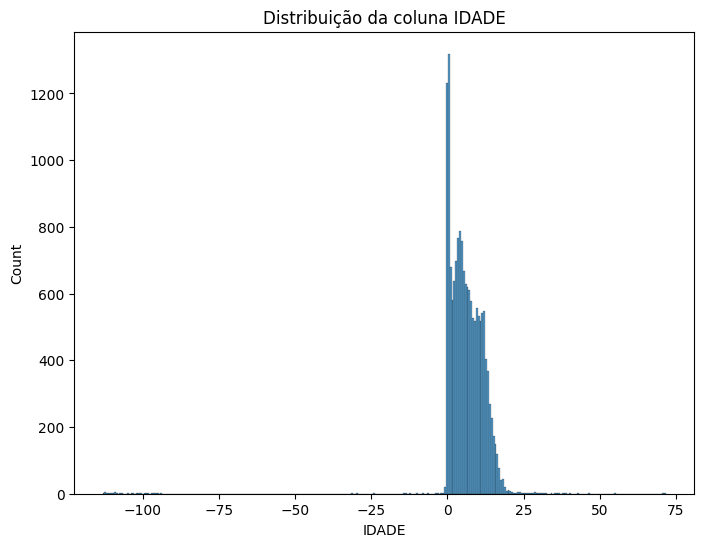

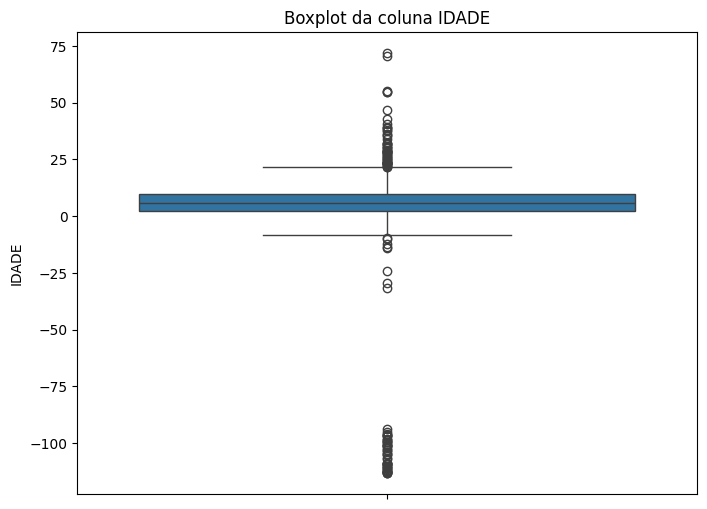

In [4]:
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')

from scripts.analise_exploratoria import analise_descritiva
analise_descritiva(df, 'IDADE')

from scripts.analise_exploratoria import visualizacao
visualizacao(df, 'IDADE')

De acordo com o boxplot e com o histograma, é possível ver uma concentração de idades que estão próximas dos -100 anos. Para o tratamento desses dados, será considerada a mesma idade, só que acrescida de 100 anos e positiva.

Para o tratamento dos valores negativos, será feita apenas a inversão, considerando que houve um equívoco na hora de registrar a data de nascimento (DN) e a data de atendimento.

In [5]:
# Quantidade de idades menores do que -90 anos.
qtd_idades_outliers_negativos = (df['IDADE'] < -90).sum()
print(f"A coluna 'IDADE' possui {qtd_idades_outliers_negativos} valores menores do que -90 ({qtd_idades_outliers_negativos/df.shape[0]*100:.2f}%).\n")

# Para esses outliers, recalcular a idade
mask = df['IDADE'] < -90
df.loc[mask, 'IDADE'] = np.abs(df.loc[mask, 'IDADE'] + 100)

# Tratamento para idades negativas
mask = df['IDADE'] < 0
df.loc[mask, 'IDADE'] = df.loc[mask, 'IDADE'].abs()

analise_descritiva(df, 'IDADE')

A coluna 'IDADE' possui 48 valores menores do que -90 (0.27%).

A coluna 'IDADE' possui 1496 valores nulos (8.37%).

A coluna 'IDADE' possui 0 valores negativos (0.00%).

A coluna 'IDADE' possui 184 valores zero (1.03%).

Média da coluna 'IDADE': 6.36

Mediana da coluna 'IDADE': 5.67

Moda da coluna 'IDADE': 0.01

Desvio padrão da coluna 'IDADE': 4.97

Variância da coluna 'IDADE': 24.70

Quartis da coluna 'IDADE': 
0.25     2.23
0.50     5.67
0.75    10.00
Name: IDADE, dtype: float64



Agora, tratamento dos campos de idade que estão vazios. Para tratar a idade vazia, será substituída pela média de idade de todos com o mesmo diagnóstico.

In [6]:
# Preencher as idades faltantes
from scripts.analise_exploratoria import define_valores_ausentes
df = define_valores_ausentes(df, df_classe, 'IDADE', 'CLASSE', 'Id')

In [7]:
analise_descritiva(df, 'IDADE')

A coluna 'IDADE' possui 0 valores nulos (0.00%).

A coluna 'IDADE' possui 0 valores negativos (0.00%).

A coluna 'IDADE' possui 134 valores zero (0.91%).

Média da coluna 'IDADE': 6.43

Mediana da coluna 'IDADE': 6.27

Moda da coluna 'IDADE': 6.95

Desvio padrão da coluna 'IDADE': 4.80

Variância da coluna 'IDADE': 23.04

Quartis da coluna 'IDADE': 
0.25    2.64
0.50    6.27
0.75    9.52
Name: IDADE, dtype: float64



In [8]:
display(df.head(4))

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,2,3.5,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,NaN,Não Calculado,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
1,3,0.0,0,NaN,12/06/01,08/05/05,4.05,SULA,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
2,4,8.1,65,19.0,15/10/09,21/04/09,0.50,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
3,6,26.0,112,21.0,22/08/03,26/05/99,4.40,GS,Normais,100.0,60.0,Normal,Desdob fixo,ausente,100,Assintomático,NaN,M,2 - Check-up,NaN


Agora, a coluna de idade não tem valores negativos e nem nulos, o que permite a partir de agora tratar outros atributos.

#### Análise do peso

A coluna 'Peso' possui 260 valores nulos (1.77%).

A coluna 'Peso' possui 1 valores negativos (0.01%).

A coluna 'Peso' possui 2289 valores zero (15.54%).

Média da coluna 'Peso': 20.98

Mediana da coluna 'Peso': 17.50

Moda da coluna 'Peso': 0.00

Desvio padrão da coluna 'Peso': 18.19

Variância da coluna 'Peso': 330.87

Quartis da coluna 'Peso': 
0.25     6.0
0.50    17.5
0.75    31.0
Name: Peso, dtype: float64



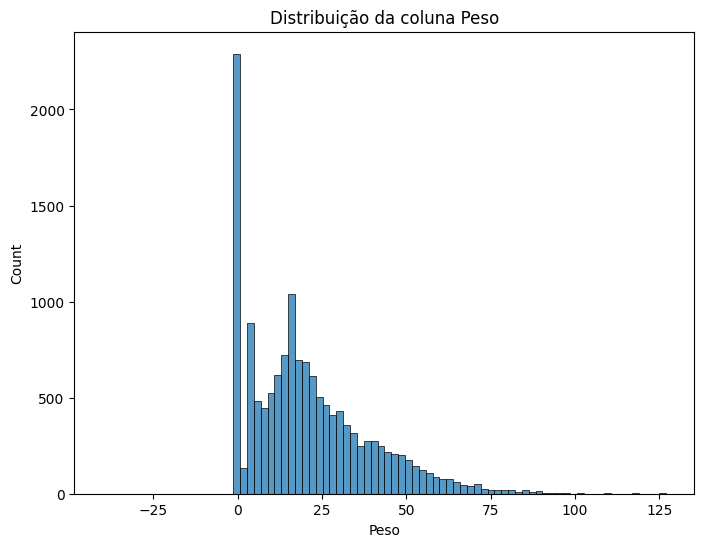

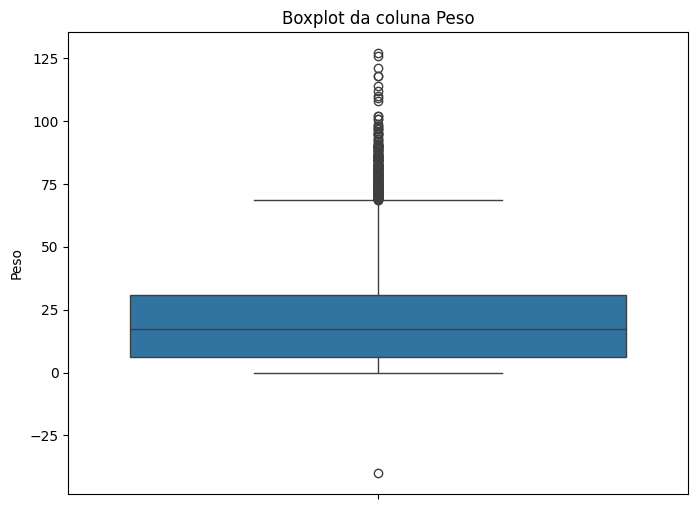

In [9]:
from scripts.analise_exploratoria import analise_descritiva
analise_descritiva(df, 'Peso')

from scripts.analise_exploratoria import visualizacao
visualizacao(df, 'Peso')

No gráfico boxplot, o limite inferior da linha começa em 0, indicando que o valor mínimo, ignorando o outlier inferior, é 0. O único valor negativo pode ser interpretado como um erro na coleta do dado. Para corrigi-lo, será considerado o mesmo peso positivo.

In [10]:
df.loc[df['Peso'] < 0, 'Peso'] = df.loc[df['Peso'] < 0, 'Peso'].abs()

Além disso, os pesos iguais a 0 são considerados inconsistentes, pois não fazem sentido no contexto dessa aplicação. O mesmo para pesos sem informação (nulos). Para endereçar esses problemas, será utilizada a tabela de peso e altura por idade dos 0 aos 18 anos para cada gênero, disponível [aqui](https://www.unimed.coop.br/viver-bem/pais-e-filhos/estatura-por-idade). Para pacientes maiores do que 18 anos, será colocado o peso médio para o gênero.
Essa abordagem só é possível pois tratamos a coluna de idade.

Além disso, como a função depende, além da idade, do gênero do paciente, então é necessário também fazer um tratamento para os casos de sexo inválido ou ausente.

#### Sexo

In [11]:
from scripts.analise_exploratoria import analise_descritiva_categorica
analise_descritiva_categorica(df, 'SEXO')

from scripts.analise_exploratoria import normalizar_sexo
df['SEXO'] = df['SEXO'].apply(normalizar_sexo)
analise_descritiva_categorica(df, 'SEXO')

Existem 6 tipos de categorias diferentes para a coluna SEXO.

Categorias da coluna SEXO e a quantidade: 

SEXO
M                7253
F                5393
Indeterminado    1332
Masculino         480
Feminino          201
masculino          65
Name: count, dtype: int64

A coluna 'SEXO' possui 3 valores nulos (0.02%).

Existem 3 tipos de categorias diferentes para a coluna SEXO.

Categorias da coluna SEXO e a quantidade: 

SEXO
M    7798
F    5594
I    1335
Name: count, dtype: int64

A coluna 'SEXO' possui 0 valores nulos (0.00%).



O dataset tem uma quantidade considerável de sexos classificados como indeterminados ("I"). Após uma inspeção manual nos dados, foi possível perceber que muitas instâncias cujo sexo é indeterminado também não possuem boa parte das outras informações. Dessa maneira, as instâncias que não tiverem pelo menos 70% dos outros atributos serão removidos do dataset.

In [12]:
from scripts.analise_exploratoria import remove_objetos_incompletos
df = remove_objetos_incompletos(df)

df_invalidos = df[df['SEXO'] == 'I']
print(f'São {df_invalidos.shape[0]} objetos com o sexo inválido.\n')

São 1335 objetos com o sexo inválido.



,Id,qtd_nulos
50,65,14
67,86,14
73,94,5
103,131,14
128,161,14
...,...,...
14680,17820,5
14692,17834,14
14698,17840,14
14706,17849,5


Existem 20 atributos no data frame. O limite é 14 colunas nulas.
Removendo 753 objetos com mais ou igual do que 14 colunas nulas.

São 582 objetos com o sexo inválido.



Ainda sobraram 582 objetos com o sexo inválido. Todos eles serão atribuídos ao "F" para equilibrar (depois tratar de outra forma).

In [13]:
# Substituir todos os valores 'I' por 'F' na coluna 'SEXO'
df['SEXO'] = df['SEXO'].replace('I', 'F')

from scripts.analise_exploratoria import define_medida
# Completar o peso para pesos iguais a 0 ou null.
define_medida(df, 'Peso')

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,2,3.50,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,NaN,Não Calculado,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
1,3,16.51,0,NaN,12/06/01,08/05/05,4.05,SULA,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
2,4,8.10,65,19.0,15/10/09,21/04/09,0.50,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
3,6,26.00,112,21.0,22/08/03,26/05/99,4.40,GS,Normais,100.0,60.0,Normal,Desdob fixo,ausente,100,Assintomático,NaN,M,2 - Check-up,NaN
4,7,40.00,151,18.0,14/01/08,14/08/95,12.89,SAME,Normais,NaN,NaN,Não Calculado,Normal,ausente,96,Dor precordial,NaN,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14722,17868,10.60,85,15.0,28/12/06,06/12/04,2.14,NaN,Normais,90.0,50.0,Não Calculado,Normal,ausente,100,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14723,17869,9.50,76,16.0,03/02/06,06/12/04,1.20,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14724,17871,65.00,175,21.0,03/08/07,16/02/84,24.34,Medial,Normais,126.0,80.0,Não Calculado,Normal,ausente,76,Dor precordial,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
14725,17872,27.00,134,15.0,04/10/04,03/12/27,24.03,GS,Normais,90.0,50.0,Não Calculado,Normal,Sistólico,NaN,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial


#### Altura

A coluna 'Altura' possui 0 valores nulos (0.00%).

A coluna 'Altura' possui 0 valores negativos (0.00%).

A coluna 'Altura' possui 3045 valores zero (21.79%).

Média da coluna 'Altura': 87.44

Mediana da coluna 'Altura': 101.00

Moda da coluna 'Altura': 0.00

Desvio padrão da coluna 'Altura': 55.11

Variância da coluna 'Altura': 3036.58

Quartis da coluna 'Altura': 
0.25     50.0
0.50    101.0
0.75    132.0
Name: Altura, dtype: float64



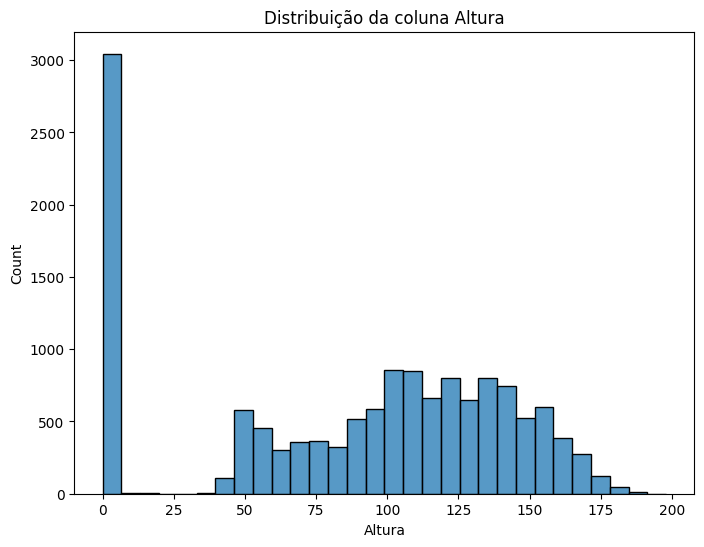

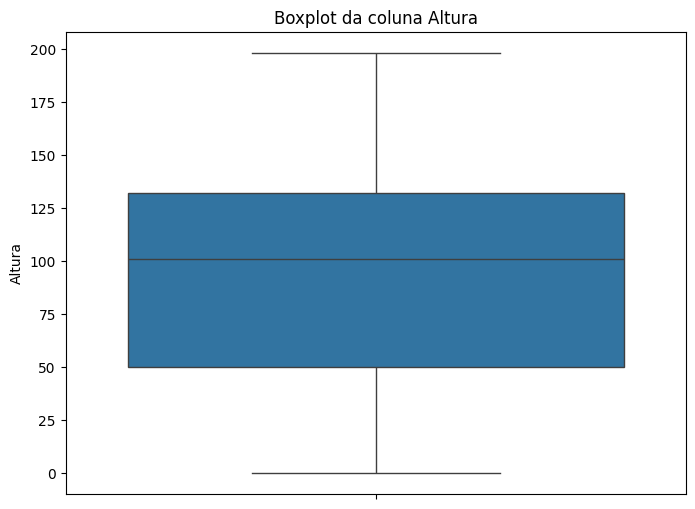

In [14]:
from scripts.analise_exploratoria import analise_descritiva
analise_descritiva(df, 'Altura')

from scripts.analise_exploratoria import visualizacao
visualizacao(df, 'Altura')

In [15]:
print(f'A Altura tem a unidade {df["Altura"].dtype}.')
define_medida(df, 'Altura')

A Altura tem a unidade int64.


/home/paula/Área de trabalho/template-implementacao/scripts/analise_exploratoria.py:425: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[103.4 167.8 167.8 ... 117.5 149.6 144.7]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask, medida] = df.loc[mask].apply(


,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,2,3.50,50.0,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,NaN,Não Calculado,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
1,3,16.51,103.4,NaN,12/06/01,08/05/05,4.05,SULA,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
2,4,8.10,65.0,19.0,15/10/09,21/04/09,0.50,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
3,6,26.00,112.0,21.0,22/08/03,26/05/99,4.40,GS,Normais,100.0,60.0,Normal,Desdob fixo,ausente,100,Assintomático,NaN,M,2 - Check-up,NaN
4,7,40.00,151.0,18.0,14/01/08,14/08/95,12.89,SAME,Normais,NaN,NaN,Não Calculado,Normal,ausente,96,Dor precordial,NaN,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14722,17868,10.60,85.0,15.0,28/12/06,06/12/04,2.14,NaN,Normais,90.0,50.0,Não Calculado,Normal,ausente,100,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14723,17869,9.50,76.0,16.0,03/02/06,06/12/04,1.20,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14724,17871,65.00,175.0,21.0,03/08/07,16/02/84,24.34,Medial,Normais,126.0,80.0,Não Calculado,Normal,ausente,76,Dor precordial,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
14725,17872,27.00,134.0,15.0,04/10/04,03/12/27,24.03,GS,Normais,90.0,50.0,Não Calculado,Normal,Sistólico,NaN,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial


### Convênio

In [16]:
from scripts.analise_exploratoria import analise_descritiva_categorica
analise_descritiva_categorica(df, 'Convenio')

Existem 407 tipos de categorias diferentes para a coluna Convenio.

Categorias da coluna Convenio e a quantidade: 

Convenio
GS              2221
UR              1840
SB               580
GRUPO            449
CAMED            391
                ... 
S.HELEN            1
STA HE             1
Medial saúde       1
STA HEL.           1
S.Am               1
Name: count, Length: 407, dtype: int64

A coluna 'Convenio' possui 3740 valores nulos (26.76%).



Também irá para lowercase o convênio.

In [17]:
df['Convenio'] = df['Convenio'].str.lower()
quant_categorias = df['Convenio'].value_counts().size
print(f"Existem {quant_categorias} tipos de categorias diferentes para a coluna {'Convenio'}.\n")

Existem 292 tipos de categorias diferentes para a coluna Convenio.



Antes da normalização para letras minúsculas, havia 439 convênios distintos. Após esse procedimento, agora é 317.

Após uma inspeção manual dos dados, é possível perceber que o mesmo convênio foi registrado de forma diferente na tabela. Considerando apenas as letras minúsculas:

O convênio **Sul América** tem ocorrências na forma: "sa", "sula", "sulam", "s. america", "sul america", "sulamerica", "américa", "sul am", "america s.", "s.am", "s.america", "america", "s.a."...

O convênio **Norclínicas** tem ocorrências na forma: "norcl", "norclinicas", "norclin", "norclin.", "norclinica", "norc"...

Por isso, será feita uma normalização manual, mapeando todos para um valor padrão.

In [18]:
from scripts.analise_exploratoria import normalizar_convenio
df['Convenio'] = df['Convenio'].apply(normalizar_convenio)

In [19]:
quant_categorias = df['Convenio'].value_counts().size
print(f"Existem {quant_categorias} tipos de categorias diferentes para a coluna {'Convenio'}.\n")

analise_descritiva_categorica(df, 'Convenio')

Existem 162 tipos de categorias diferentes para a coluna Convenio.

Existem 162 tipos de categorias diferentes para a coluna Convenio.

Categorias da coluna Convenio e a quantidade: 

Convenio
gs                     2226
unimed recife          1950
sul america             703
camed                   683
sb                      582
                       ... 
embra                     1
medial saúde              1
hospital residência       1
c. coração                1
jorge de medeiros         1
Name: count, Length: 162, dtype: int64

A coluna 'Convenio' possui 3740 valores nulos (26.76%).



In [20]:
convenios_unicos = df['Convenio'].unique()

# Imprimindo os resultados
print(convenios_unicos)

['gs' 'sul america' nan 'same' 'unimed recife' 'grupo' 'part' 'sb' 'ug'
 'norclinicas' 'camed' 'medial' 'ct' 'cc' 'semepe' 'sus' 'funcef' 'ideal'
 'santa helena' 'fusex' 'real saude' 'unibanco' '35971' 'tabela' 'viva'
 'blserv' 'aeronautica' 'fachesf' 'medservice' 'mediservice' 'mms' 'asl'
 'as' 'cassi' 'sbpref' 'circulo' 'u g' 'notredame' 'celpos' 'saude recife'
 'santa clara' 's. cx' 'assef' 'oab' 'assefaz' 'blue life' 'notre dame'
 'petrobras' 'campe' 'comsaúde' 'gc' 'particular' 'bradesco' 'part.'
 'círculo' 'chesf' 'fachesp' 'agf' 'gama' 'unimed' 'fisco' 'reemb.'
 'cortesia' '39561' 's. caixa' 'saude excelsior' 'celpe' 'cass' 'ree/sa'
 'tab' 'sh' 'uniban' 'unib.' 'embrat' 'tab/ur' 'alians' 'fisco saude'
 'golden' '38001' 'saúde caixa' 'amil' 'amep' 'cort' 'c cor' 'patrt'
 'rela saude' 'ideal s.' 'saq' 'embratel' 'comsaude' 'assefa' '17999'
 'fiscosaude' 'plan' 'staher' 'semep' 'u.g.' '36170' 'golden cross' 's.b.'
 'banco  central' 'cassi + tab' 'unib' 'plan assiste' 'ucaruaru'
 'o

Ainda há bastante convênio com o valor nulo que serão substituídos pelo campo "sem info"

In [21]:
df['Convenio'] = df['Convenio'].fillna('sem info')

### Pulsos

In [22]:
from scripts.analise_exploratoria import analise_descritiva_categorica
analise_descritiva_categorica(df, 'PULSOS')

Existem 7 tipos de categorias diferentes para a coluna PULSOS.

Categorias da coluna PULSOS e a quantidade: 

PULSOS
Normais                13395
Amplos                    45
Outro                     39
Femorais diminuidos       36
Diminuídos                17
NORMAIS                    2
AMPLOS                     1
Name: count, dtype: int64

A coluna 'PULSOS' possui 439 valores nulos (3.14%).



O primeiro tratamento aplicado à coluna de 'PULSOS' será a normalização. Todos os valores serão transformados para letra minúscula. Dessa maneira, isso corrigirá a diferença entre os pulsos sendo categorizados de maneira diferente para "NORMAIS" e "Normais" e "AMPLOS" e "amplos".

In [23]:
df['PULSOS'] = df['PULSOS'].str.lower()
analise_descritiva_categorica(df, 'PULSOS')

Existem 5 tipos de categorias diferentes para a coluna PULSOS.

Categorias da coluna PULSOS e a quantidade: 

PULSOS
normais                13397
amplos                    46
outro                     39
femorais diminuidos       36
diminuídos                17
Name: count, dtype: int64

A coluna 'PULSOS' possui 439 valores nulos (3.14%).



In [24]:
# Os valores nulos serão substituídos por "outro"
df['PULSOS'] = df['PULSOS'].fillna('outro')

analise_descritiva_categorica(df, 'PULSOS')

Existem 5 tipos de categorias diferentes para a coluna PULSOS.

Categorias da coluna PULSOS e a quantidade: 

PULSOS
normais                13397
outro                    478
amplos                    46
femorais diminuidos       36
diminuídos                17
Name: count, dtype: int64

A coluna 'PULSOS' possui 0 valores nulos (0.00%).



### Pressão arterial sistólica

O que significa a pressão arterial sistólica?

A coluna 'PA SISTOLICA' possui 5742 valores nulos (41.09%).

A coluna 'PA SISTOLICA' possui 0 valores negativos (0.00%).

A coluna 'PA SISTOLICA' possui 0 valores zero (0.00%).

Média da coluna 'PA SISTOLICA': 101.40

Mediana da coluna 'PA SISTOLICA': 100.00

Moda da coluna 'PA SISTOLICA': 100.00

Desvio padrão da coluna 'PA SISTOLICA': 15.00

Variância da coluna 'PA SISTOLICA': 224.87

Quartis da coluna 'PA SISTOLICA': 
0.25     90.0
0.50    100.0
0.75    110.0
Name: PA SISTOLICA, dtype: float64



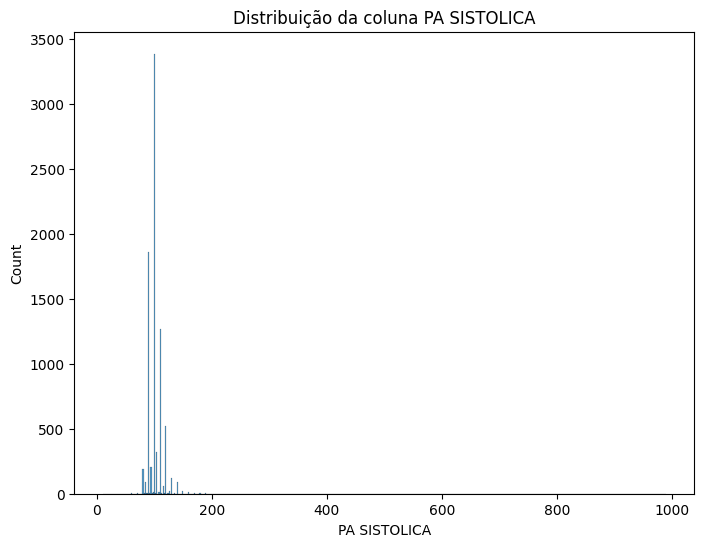

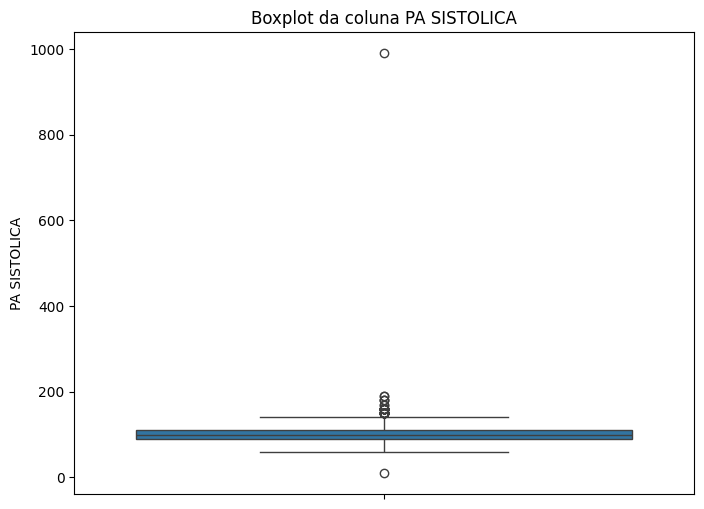

In [25]:
from scripts.analise_exploratoria import analise_descritiva
analise_descritiva(df, 'PA SISTOLICA')

from scripts.analise_exploratoria import visualizacao
visualizacao(df, 'PA SISTOLICA')

O problema da coluna PA SISTOLICA é que existem muitos valores nulos. Para endereçar esse problema, para a PA SISTOLICA nula, será substituída pela moda dos objetos com a mesma pressão.

In [26]:
from scripts.analise_exploratoria import preencher_pressao_arterial_por_pulso
df = preencher_pressao_arterial_por_pulso(df, 'PA SISTOLICA')
analise_descritiva(df, 'PA SISTOLICA')

A coluna 'PA SISTOLICA' possui 0 valores nulos (0.00%).

A coluna 'PA SISTOLICA' possui 0 valores negativos (0.00%).

A coluna 'PA SISTOLICA' possui 0 valores zero (0.00%).

Média da coluna 'PA SISTOLICA': 101.13

Mediana da coluna 'PA SISTOLICA': 100.00

Moda da coluna 'PA SISTOLICA': 100.00

Desvio padrão da coluna 'PA SISTOLICA': 11.66

Variância da coluna 'PA SISTOLICA': 136.04

Quartis da coluna 'PA SISTOLICA': 
0.25    100.0
0.50    100.0
0.75    100.0
Name: PA SISTOLICA, dtype: float64



In [27]:
# Tratamento do outlier com o valor maior do que 500: Ser igual à moda
df.loc[df['PA SISTOLICA'] > 500, 'PA SISTOLICA'] = 100

### Pressão arterial diastólica

O que significa esse atributo?
O mesmo tratamento do que a PA Sistólica

A coluna 'PA DIASTOLICA' possui 5752 valores nulos (41.16%).

A coluna 'PA DIASTOLICA' possui 0 valores negativos (0.00%).

A coluna 'PA DIASTOLICA' possui 0 valores zero (0.00%).

Média da coluna 'PA DIASTOLICA': 62.37

Mediana da coluna 'PA DIASTOLICA': 60.00

Moda da coluna 'PA DIASTOLICA': 60.00

Desvio padrão da coluna 'PA DIASTOLICA': 8.95

Variância da coluna 'PA DIASTOLICA': 80.13

Quartis da coluna 'PA DIASTOLICA': 
0.25    60.0
0.50    60.0
0.75    70.0
Name: PA DIASTOLICA, dtype: float64



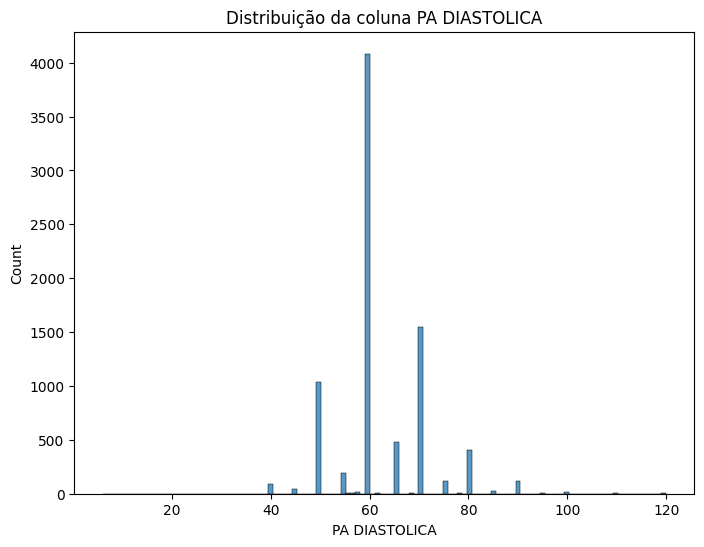

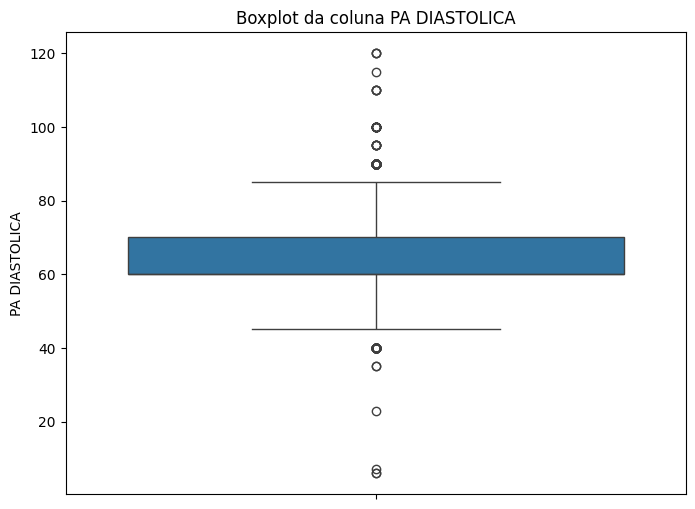

In [28]:
from scripts.analise_exploratoria import analise_descritiva
analise_descritiva(df, 'PA DIASTOLICA')

from scripts.analise_exploratoria import visualizacao
visualizacao(df, 'PA DIASTOLICA')

In [29]:
df = preencher_pressao_arterial_por_pulso(df, 'PA DIASTOLICA')
analise_descritiva(df, 'PA DIASTOLICA')

A coluna 'PA DIASTOLICA' possui 0 valores nulos (0.00%).

A coluna 'PA DIASTOLICA' possui 0 valores negativos (0.00%).

A coluna 'PA DIASTOLICA' possui 0 valores zero (0.00%).

Média da coluna 'PA DIASTOLICA': 61.74

Mediana da coluna 'PA DIASTOLICA': 60.00

Moda da coluna 'PA DIASTOLICA': 60.00

Desvio padrão da coluna 'PA DIASTOLICA': 7.13

Variância da coluna 'PA DIASTOLICA': 50.85

Quartis da coluna 'PA DIASTOLICA': 
0.25    60.0
0.50    60.0
0.75    60.0
Name: PA DIASTOLICA, dtype: float64



### PPA

O que significa essa variável?

In [30]:
analise_descritiva_categorica(df, 'PPA')
df['PPA'] = df['PPA'].str.lower()

# O calor #value! ser endereçado para 
df['PPA'] = df['PPA'].replace('#value!', 'indefinido')
# Para endereçar os campos nulos
df['PPA'] = df['PPA'].fillna('indefinido')

analise_descritiva_categorica(df, 'PPA')

Existem 9 tipos de categorias diferentes para a coluna PPA.

Categorias da coluna PPA e a quantidade: 

PPA
Não Calculado          7370
Normal                 4917
#VALUE!                 743
Pre-Hipertensão PAD     182
HAS-2 PAS               170
Pre-Hipertensão PAS     159
HAS-1 PAS               119
HAS-1 PAD                69
HAS-2 PAD                48
Name: count, dtype: int64

A coluna 'PPA' possui 197 valores nulos (1.41%).

Existem 9 tipos de categorias diferentes para a coluna PPA.

Categorias da coluna PPA e a quantidade: 

PPA
não calculado          7370
normal                 4917
indefinido              940
pre-hipertensão pad     182
has-2 pas               170
pre-hipertensão pas     159
has-1 pas               119
has-1 pad                69
has-2 pad                48
Name: count, dtype: int64

A coluna 'PPA' possui 0 valores nulos (0.00%).



### B2

O que significa?

In [31]:
analise_descritiva_categorica(df, 'B2')
df['B2'] = df['B2'].str.lower()

# Tratar valores nulos
df['B2'] = df['B2'].fillna('outro')

analise_descritiva_categorica(df, 'B2')

Existem 5 tipos de categorias diferentes para a coluna B2.

Categorias da coluna B2 e a quantidade: 

B2
Normal           12951
Hiperfonética      283
Desdob fixo        157
Outro               86
Única               73
Name: count, dtype: int64

A coluna 'B2' possui 424 valores nulos (3.03%).

Existem 5 tipos de categorias diferentes para a coluna B2.

Categorias da coluna B2 e a quantidade: 

B2
normal           12951
outro              510
hiperfonética      283
desdob fixo        157
única               73
Name: count, dtype: int64

A coluna 'B2' possui 0 valores nulos (0.00%).



### Sopro

In [32]:
analise_descritiva_categorica(df, 'SOPRO')
df['SOPRO'] = df['SOPRO'].str.lower()

# O valor "sistolico e diastólico" ser endereçado para "diastólico" para equilibrar
df['SOPRO'] = df['SOPRO'].replace('sistolico e diastólico', 'diastólico')
# Para endereçar os campos nulos
df['SOPRO'] = df['SOPRO'].fillna('ausente')
analise_descritiva_categorica(df, 'SOPRO')

Existem 7 tipos de categorias diferentes para a coluna SOPRO.

Categorias da coluna SOPRO e a quantidade: 

SOPRO
ausente                   8723
Sistólico                 3896
sistólico                  888
contínuo                    27
Contínuo                    17
diastólico                   8
Sistolico e diastólico       3
Name: count, dtype: int64

A coluna 'SOPRO' possui 412 valores nulos (2.95%).

Existem 4 tipos de categorias diferentes para a coluna SOPRO.

Categorias da coluna SOPRO e a quantidade: 

SOPRO
ausente       9135
sistólico     4784
contínuo        44
diastólico      11
Name: count, dtype: int64

A coluna 'SOPRO' possui 0 valores nulos (0.00%).



### FC

A coluna 'FC' possui 1157 valores nulos (8.28%).

A coluna 'FC' possui 0 valores negativos (0.00%).

A coluna 'FC' possui 0 valores zero (0.00%).

Média da coluna 'FC': 94.08

Mediana da coluna 'FC': 90.00

Moda da coluna 'FC': 80.00

Desvio padrão da coluna 'FC': 111.02

Variância da coluna 'FC': 12325.72

Quartis da coluna 'FC': 
0.25     80.0
0.50     90.0
0.75    100.0
Name: FC, dtype: float64



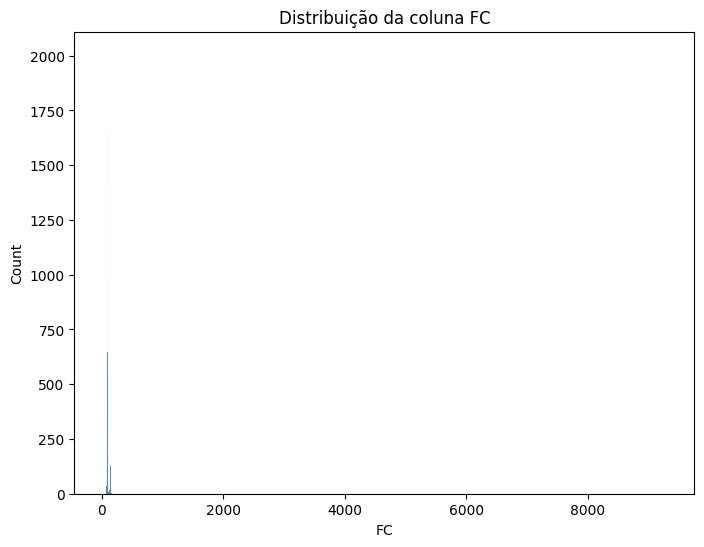

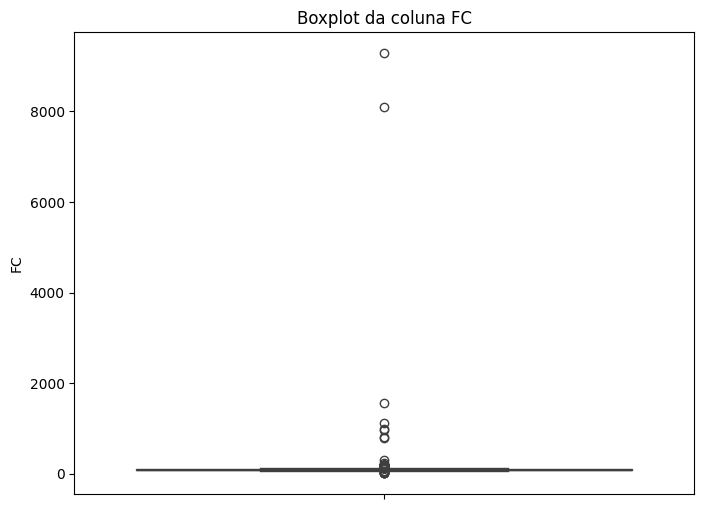

In [33]:
df['FC'] = pd.to_numeric(df['FC'], errors='coerce')
analise_descritiva(df, 'FC')
visualizacao(df, 'FC')

A coluna 'FC' possui 0 valores nulos (0.00%).

A coluna 'FC' possui 0 valores negativos (0.00%).

A coluna 'FC' possui 0 valores zero (0.00%).

Média da coluna 'FC': 92.08

Mediana da coluna 'FC': 90.00

Moda da coluna 'FC': 90.00

Desvio padrão da coluna 'FC': 16.01

Variância da coluna 'FC': 256.30

Quartis da coluna 'FC': 
0.25     80.0
0.50     90.0
0.75    100.0
Name: FC, dtype: float64



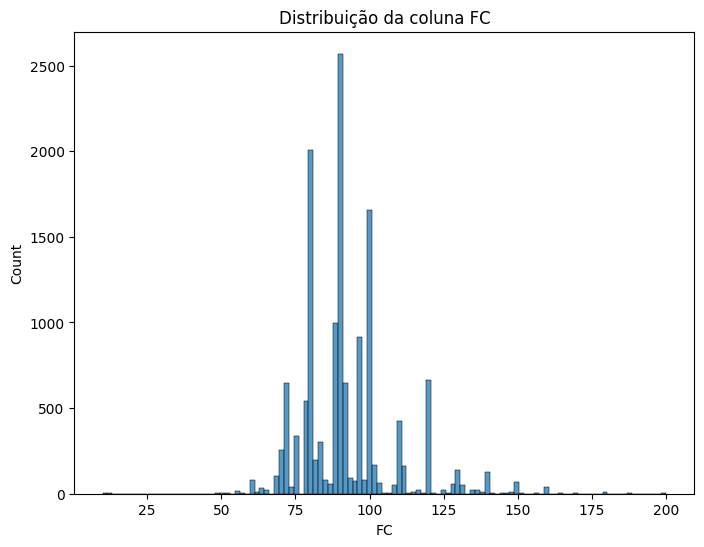

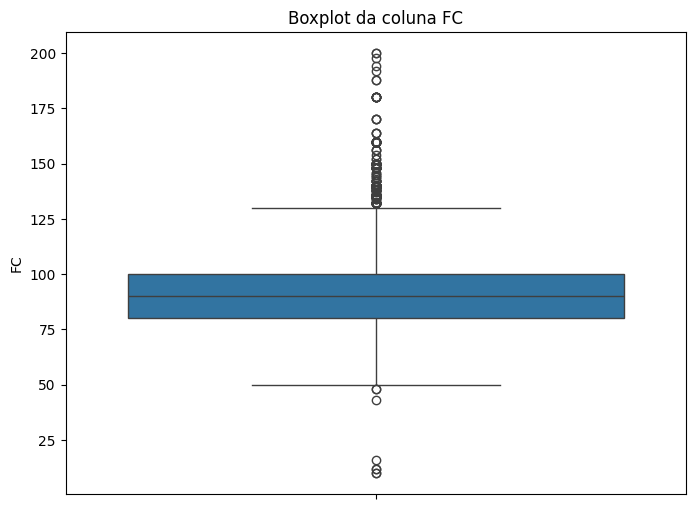

In [34]:
# Tratamento dos outliers com o valor maior do que 200: Ser igual à moda
df.loc[df['FC'] > 200, 'FC'] = df['FC'].median()

# Tratamento dos valores nulos
df['FC'] = df['FC'].fillna(  df['FC'].median()  )

analise_descritiva(df, 'FC')
visualizacao(df, 'FC')

### HDA1

Dar um carinho maior aos valores nulos.

In [35]:
analise_descritiva_categorica(df, 'HDA 1')
df['HDA 1'] = df['HDA 1'].str.lower()
df['HDA 1'] = df['HDA 1'].fillna( 'outro' )
analise_descritiva_categorica(df, 'HDA 1')

Existem 8 tipos de categorias diferentes para a coluna HDA 1.

Categorias da coluna HDA 1 e a quantidade: 

HDA 1
Assintomático      7514
Dor precordial      699
Dispneia            634
Palpitacao          476
Cianose             254
Desmaio/tontura     227
Outro               170
Ganho de peso       139
Name: count, dtype: int64

A coluna 'HDA 1' possui 3861 valores nulos (27.63%).

Existem 8 tipos de categorias diferentes para a coluna HDA 1.

Categorias da coluna HDA 1 e a quantidade: 

HDA 1
assintomático      7514
outro              4031
dor precordial      699
dispneia            634
palpitacao          476
cianose             254
desmaio/tontura     227
ganho de peso       139
Name: count, dtype: int64

A coluna 'HDA 1' possui 0 valores nulos (0.00%).



### HDA2

In [36]:
analise_descritiva_categorica(df, 'HDA2')
df['HDA2'] = df['HDA2'].str.lower()
df['HDA2'] = df['HDA2'].fillna( 'vazio' )
analise_descritiva_categorica(df, 'HDA2')

Existem 8 tipos de categorias diferentes para a coluna HDA2.

Categorias da coluna HDA2 e a quantidade: 

HDA2
Palpitacao         126
Dispneia           105
Dor precordial      83
Cianose             74
Desmaio/tontura     64
Outro               60
Ganho de peso       26
Assintomático        1
Name: count, dtype: int64

A coluna 'HDA2' possui 13435 valores nulos (96.14%).

Existem 9 tipos de categorias diferentes para a coluna HDA2.

Categorias da coluna HDA2 e a quantidade: 

HDA2
vazio              13435
palpitacao           126
dispneia             105
dor precordial        83
cianose               74
desmaio/tontura       64
outro                 60
ganho de peso         26
assintomático          1
Name: count, dtype: int64

A coluna 'HDA2' possui 0 valores nulos (0.00%).



### Motivo 1

In [37]:
analise_descritiva_categorica(df, 'MOTIVO1')
df['MOTIVO1'] = df['MOTIVO1'].str.lower()
df['MOTIVO1'] = df['MOTIVO1'].fillna( '7 - outro' )
analise_descritiva_categorica(df, 'MOTIVO1')

Existem 5 tipos de categorias diferentes para a coluna MOTIVO1.

Categorias da coluna MOTIVO1 e a quantidade: 

MOTIVO1
5 - Parecer cardiológico           6492
6 - Suspeita de cardiopatia        4798
1 - Cardiopatia já estabelecida    1137
2 - Check-up                        842
7 - Outro                           385
Name: count, dtype: int64

A coluna 'MOTIVO1' possui 320 valores nulos (2.29%).

Existem 5 tipos de categorias diferentes para a coluna MOTIVO1.

Categorias da coluna MOTIVO1 e a quantidade: 

MOTIVO1
5 - parecer cardiológico           6492
6 - suspeita de cardiopatia        4798
1 - cardiopatia já estabelecida    1137
2 - check-up                        842
7 - outro                           705
Name: count, dtype: int64

A coluna 'MOTIVO1' possui 0 valores nulos (0.00%).



### Motivo 2

In [38]:
analise_descritiva_categorica(df, 'MOTIVO2')
df['MOTIVO2'] = df['MOTIVO2'].str.lower()
df['MOTIVO2'] = df['MOTIVO2'].fillna( 'outro' )
analise_descritiva_categorica(df, 'MOTIVO2')

Existem 16 tipos de categorias diferentes para a coluna MOTIVO2.

Categorias da coluna MOTIVO2 e a quantidade: 

MOTIVO2
5 - Cirurgia                           3429
6 - Sopro                              2430
1 - Cardiopatia congenica              1018
Outro                                   928
5 - Atividade física                    924
6 - Dor precordial                      540
6 - Palpitação/taquicardia/arritmia     466
6 - HAS/dislipidemia/obesidade          346
6 - Dispnéia                            278
6 - Cianose                             133
1 - Cardiopatia adquirida               103
6 - Cardiopatia na familia               45
6 - Cansaço                              14
5 - Uso de cisaprida                      5
6 - Cianose e dispnéia                    5
6 - Alterações de pulso/perfusão          4
Name: count, dtype: int64

A coluna 'MOTIVO2' possui 3306 valores nulos (23.66%).

Existem 16 tipos de categorias diferentes para a coluna MOTIVO2.

Categorias da coluna MOTIV

---
## Pré-processamento

#### Eliminação manual de atributos
No conjunto de dados fornecido, é possível afirmar que existem atributos que não vão contribuir para a tarefa preditiva pois não estão relacionados com a estimativa do diagnóstico, como é o caso do id, data de atendimento, convênio e data de nascimento.

A data de nascimento e consulta podem ser eliminadas, pois é mais significativo para a aplicação saber a idade do paciente na época do diagnóstico, informação que é expressa pelo atributo idade.

Em uma primeira análise, considera-se que o convênio utilizado não tem relação com o diagnóstico. Porém, pode ser questionado nas próximas versões.

In [39]:
# Unir os dois dataframes para não dar problema de tamanho para unir os dois
df = pd.merge(df, df_classe, on = 'Id', how = 'left')
display(df.columns)

Index(['Id', 'Peso', 'Altura', 'IMC', 'Atendimento', 'DN', 'IDADE', 'Convenio',
       'PULSOS', 'PA SISTOLICA', 'PA DIASTOLICA', 'PPA', 'B2', 'SOPRO', 'FC',
       'HDA 1', 'HDA2', 'SEXO', 'MOTIVO1', 'MOTIVO2', 'CLASSE'],
      dtype='object')

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(pd.crosstab(df['HDA2'], df['CLASSE']))

# sns.histplot(data = df, x = 'PULSO', hue = 'CLASSE', kde = True)
# sns.violinplot(x = 'PPA', y = 'IMC', data = df)
# print(pd.crosstab(df['PPA'], df['CLASSE']))

'''
plt.title('Distribuição dos Pulsos por Classe')
plt.xlabel('Valor do Pulso')
plt.ylabel('Frequência')
plt.show()
'''

CLASSE           anormal  normal  sem info
HDA2                                      
assintomático          1       0         0
cianose               48      23         3
desmaio/tontura       22      41         1
dispneia              44      60         1
dor precordial        26      57         0
ganho de peso          8      18         0
outro                 25      35         0
palpitacao            41      85         0
vazio               5200    7811       424


"\nplt.title('Distribuição dos Pulsos por Classe')\nplt.xlabel('Valor do Pulso')\nplt.ylabel('Frequência')\nplt.show()\n"

#### Transformação de Dados

A primeira transformação será a conversão simbólico-numérico para os atributos nominais sem relação de ordem entre os valores do atributo. A inexistência de ordem deve continuar. É o caso dos atributos:
- PULSOS
- B2
- SOPRO
- HDA1
- HDA2
- SEXO
- MOTIVO1
- MOTIVO2

Segundo a documentação:
The TargetEncoder uses the target mean conditioned on the categorical feature for encoding unordered categories, i.e. nominal categories [PAR] [MIC]. This encoding scheme is useful with categorical features with high cardinality, where one-hot encoding would inflate the feature space making it more expensive for a downstream model to process. A classical example of high cardinality categories are location based such as zip code or region.

In [41]:
# Sexo
df['SEXO'] = df['SEXO'].map({'M': 0, 'F': 1})

### Transforming the prediction target || https://scikit-learn.org/stable/modules/preprocessing_targets.html#preprocessing-targets

In [42]:
# Conferir a distribuição das classes
analise_descritiva_categorica(df, 'CLASSE')

# Apagar aqueles que são de classe "sem info"
df.drop(df[df['CLASSE'] == 'sem info'].index, inplace=True)

# Apagar objetos duplicados
df.drop_duplicates(subset = df.columns[1:-1], keep = 'first', inplace = True)

Existem 3 tipos de categorias diferentes para a coluna CLASSE.

Categorias da coluna CLASSE e a quantidade: 

CLASSE
normal      8130
anormal     5415
sem info     429
Name: count, dtype: int64

A coluna 'CLASSE' possui 0 valores nulos (0.00%).



In [43]:
# Encode a classe
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_classe['CLASSE'])

print(le.classes_) # anormal and normal

df_classe['CLASSE'] = le.transform(df_classe['CLASSE'])

['anormal' 'normal' 'sem info']


In [44]:
from sklearn.preprocessing import TargetEncoder

display(df.head(1))
# Colunas nas quais quero aplicar o TargetEncoder
cols = ['PULSOS', 'B2', 'SOPRO', 'HDA 1', 'HDA2', 'MOTIVO1', 'MOTIVO2']
target = 'CLASSE'

# Dicionário para armazenar os encoders treinados
encoders = {}

for col in cols:  
    # Conferir se a coluna existe
    if col not in df.columns:
        print(f'A coluna {col} não existe.')
        continue
        
    encoder = TargetEncoder()
    encoder.fit(X = df[[col]], y = df[target])
    df[col + '_encoded'] = encoder.transform(df[[col]]) 
    
    encoders[col] = encoder  # Salvamos o encoder para usar nos dados de teste
    df.drop(col, axis = 1, inplace=True)

display(df.head())

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,...,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2,CLASSE
0,2,3.5,50.0,14.0,25/05/05,19/05/05,0.02,gs,normais,100.0,...,não calculado,normal,ausente,128.0,dispneia,vazio,0,6 - suspeita de cardiopatia,6 - dispnéia,anormal


,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PA SISTOLICA,PA DIASTOLICA,...,FC,SEXO,CLASSE,PULSOS_encoded,B2_encoded,SOPRO_encoded,HDA 1_encoded,HDA2_encoded,MOTIVO1_encoded,MOTIVO2_encoded
0,2,3.50,50.0,14.0,25/05/05,19/05/05,0.02,gs,100.0,60.0,...,128.0,0,anormal,0.602325,0.622493,0.908749,0.500162,0.597749,0.441703,0.652635
1,3,16.51,103.4,NaN,12/06/01,08/05/05,4.05,sul america,100.0,60.0,...,88.0,0,anormal,0.602325,0.622493,0.039807,0.561319,0.597749,0.740737,0.686772
2,4,8.10,65.0,19.0,15/10/09,21/04/09,0.50,sem info,100.0,60.0,...,92.0,0,anormal,0.602325,0.622493,0.908749,0.561319,0.597749,0.747199,0.686772
3,6,26.00,112.0,21.0,22/08/03,26/05/99,4.40,gs,100.0,60.0,...,100.0,0,anormal,0.602325,0.110236,0.908749,0.561319,0.597749,0.740737,0.686772
4,7,40.00,151.0,18.0,14/01/08,14/08/95,12.89,same,100.0,60.0,...,96.0,0,anormal,0.602325,0.622493,0.908749,0.662270,0.597749,0.747199,0.686772


In [45]:
print(df.columns)

Index(['Id', 'Peso', 'Altura', 'IMC', 'Atendimento', 'DN', 'IDADE', 'Convenio',
       'PA SISTOLICA', 'PA DIASTOLICA', 'PPA', 'FC', 'SEXO', 'CLASSE',
       'PULSOS_encoded', 'B2_encoded', 'SOPRO_encoded', 'HDA 1_encoded',
       'HDA2_encoded', 'MOTIVO1_encoded', 'MOTIVO2_encoded'],
      dtype='object')


In [46]:
# Dropando colunas
df = df.drop(['Atendimento', 'DN', 'Convenio', 'IMC', 'PPA'], axis=1)

In [47]:
print('Data frame antes StandardScaler: \n', display(df.head(5)))

,Id,Peso,Altura,IDADE,PA SISTOLICA,PA DIASTOLICA,FC,SEXO,CLASSE,PULSOS_encoded,B2_encoded,SOPRO_encoded,HDA 1_encoded,HDA2_encoded,MOTIVO1_encoded,MOTIVO2_encoded
0,2,3.50,50.0,0.02,100.0,60.0,128.0,0,anormal,0.602325,0.622493,0.908749,0.500162,0.597749,0.441703,0.652635
1,3,16.51,103.4,4.05,100.0,60.0,88.0,0,anormal,0.602325,0.622493,0.039807,0.561319,0.597749,0.740737,0.686772
2,4,8.10,65.0,0.50,100.0,60.0,92.0,0,anormal,0.602325,0.622493,0.908749,0.561319,0.597749,0.747199,0.686772
3,6,26.00,112.0,4.40,100.0,60.0,100.0,0,anormal,0.602325,0.110236,0.908749,0.561319,0.597749,0.740737,0.686772
4,7,40.00,151.0,12.89,100.0,60.0,96.0,0,anormal,0.602325,0.622493,0.908749,0.662270,0.597749,0.747199,0.686772


Data frame antes StandardScaler: 
 None


## Normalização dos dados

Tem que normalizar os dados

In [48]:
from sklearn.preprocessing import StandardScaler

colunas_normalizar = [col for col in df.columns if col != 'CLASSE' and col != 'Id']
print(colunas_normalizar)
scaler = StandardScaler()
scaler.fit(df[colunas_normalizar])
df.loc[:, colunas_normalizar] = scaler.transform(df[colunas_normalizar])


['Peso', 'Altura', 'IDADE', 'PA SISTOLICA', 'PA DIASTOLICA', 'FC', 'SEXO', 'PULSOS_encoded', 'B2_encoded', 'SOPRO_encoded', 'HDA 1_encoded', 'HDA2_encoded', 'MOTIVO1_encoded', 'MOTIVO2_encoded']


/tmp/ipykernel_28244/1516722513.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.87701145 -0.87701145 -0.87701145 ...  1.14023597  1.14023597
  1.14023597]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, colunas_normalizar] = scaler.transform(df[colunas_normalizar])


In [49]:
print('Data frame após StandardScaler: \n', df.head(5))

Data frame após StandardScaler: 
    Id      Peso    Altura     IDADE  PA SISTOLICA  PA DIASTOLICA        FC  \
0   2 -1.267126 -1.843689 -1.295541     -0.090333      -0.211746  2.210180   
1   3 -0.488596 -0.238855 -0.475647     -0.090333      -0.211746 -0.248640   
2   4 -0.991858 -1.392893 -1.197886     -0.090333      -0.211746 -0.002758   
3   6  0.079295  0.019601 -0.404440     -0.090333      -0.211746  0.489006   
4   7  0.917068  1.191670  1.322831     -0.090333      -0.211746  0.243124   

       SEXO   CLASSE  PULSOS_encoded  B2_encoded  SOPRO_encoded  \
0 -0.877011  anormal        0.106729    0.215439       0.747370   
1 -0.877011  anormal        0.106729    0.215439      -1.340824   
2 -0.877011  anormal        0.106729    0.215439       0.747370   
3 -0.877011  anormal        0.106729   -4.248623       0.747370   
4 -0.877011  anormal        0.106729    0.215439       0.747370   

   HDA 1_encoded  HDA2_encoded  MOTIVO1_encoded  MOTIVO2_encoded  
0      -1.619996      0.000

---
### Experimento

Nesta seção, o experimento deve ser conduzido, utilizando os protocolos experimentais padrões e testando diferentes modelos.

In [50]:
Y = df['CLASSE']
# Dropar a classe (se não, treina com a classe)
df = df.drop(['CLASSE'], axis=1)

In [51]:
df_submit = pd.merge(df_test, df_original, on='Id', how='left')

display(df_submit.head(10))

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,8957,4.5,54,15.0,03/08/09,11/06/09,0.15,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,110,Dispneia,Outro,F,2 - Check-up,NaN
1,4246,42.4,150,19.0,23/02/06,03/03/94,12.43,MEDISE,Normais,NaN,NaN,Não Calculado,Normal,ausente,84,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
2,9089,18.1,104,17.0,16/10/07,08/02/04,3.82,CAMED,Normais,130.0,90.0,HAS-2 PAS,Normal,ausente,100,Cianose,NaN,M,5 - Parecer cardiológico,NaN
3,10606,7.7,0,NaN,09/08/04,27/11/03,0.73,SULA,Normais,NaN,NaN,Não Calculado,Normal,ausente,98,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
4,9863,16.0,0,NaN,04/07/08,29/08/04,3.99,NORCLIN.,Normais,NaN,NaN,Não Calculado,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
5,11627,0.0,0,NaN,17/12/09,12/07/06,3.56,NaN,Normais,100.0,60.0,Não Calculado,Normal,ausente,95,Ganho de peso,Dispneia,F,5 - Parecer cardiológico,NaN
6,2338,50.7,151,22.0,16/05/05,03/01/96,9.720000000000001,Medial,Normais,110.0,60.0,Normal,Normal,sistólico,80,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física
7,13378,7.9,69,17.0,07/10/03,19/04/03,0.49,GAMA,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,88,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
8,1643,NaN,90,NaN,12/12/08,22/06/06,2.57,GS,Normais,NaN,NaN,Não Calculado,Normal,ausente,110,Palpitacao,NaN,M,2 - Check-up,NaN
9,6957,0.0,0,NaN,15/05/08,03/12/01,6.69,UR,Normais,90.0,50.0,Não Calculado,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN


In [52]:
# Converte o DataFrame selecionado em uma matriz NumPy
# que é o formato esperado pela maioria dos algoritmos de machine learning

Y = Y.to_numpy()
df = df.iloc[:, 1:]
df = df.to_numpy()

In [53]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size = 0.2, random_state = 42, shuffle = True)

# Treino + Validação (70%) e Teste (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df, Y, test_size = 0.3, random_state = 42  # test_size = 30%
)

# Treino (60%) e Validação (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size = 1/7, random_state = 42  # test_size = 10%/70% ≈ 1/7
)

print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de validação:", len(X_val))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treino: 7995
Tamanho do conjunto de validação: 1333
Tamanho do conjunto de teste: 3999


#### Dicionário de modelos
Para um código modular e bem organizado, de tal forma que fique fácil adicionar algoritmos e parâmetros. Utilizei IA para me organizar com o código, como criar o dicionário com os parâmetros.


Model Evaluation: metrics
- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrix (O que significa)
- Classification_report

## Métricas avaliadas
Utilizar a função `classification_report` as principais métricas (precisão, recall, f1-score e support).

Essa função também inclui:

- macro average (A média sem pesos para cada métrica. Sem pesos significa que não leva em consideração a quantidade de ocorrências de determinada classe no dataset (support))
- weighted average (média ponderada por rótulo, levando em consideração o número de instâncias true de cada classe)
  
#### Precision

Cálculo: `tp / (tp + fp)`

De todos os que foram classificados como doentes (corretamente ou não), a precisão é a proporção daqueles que foram corretamente classificados como doentes.

#### Recall Score

Cálculo: `tp / (tp + fn)`

- Para a classe, proporção de quais foram corretamente classificados

Ou seja, a capacidade do classificador de encontrar as instâncias positivas (classificar como sendo positivo).

Na informação retornada pelo report, a informação de recall é para ambas as classes (0 e 1).

Para classificação binária:

- Sensitivity: Recall para a classe positiva
  
- Specificity: Recall para a classe negativa

#### F1-score

Cálculo: `2 * (Precision * Recall) / (Precision + Recall)`

É uma métrica que combina o precision e o recall.

#### Support

Quantidade de ocorrências de determinada classe no dataset, ou seja, quandos samples para cada classe.

#### Accuracy

Cálculo: (tp + tn) / (qtd_total_samples)

Proporção de instâncias que o modelo classificou corretamente.
  
#### Confusion Matrix

Dada uma matriz de confusão C, C[i, j] significa o número de elementos da classificação i 
classificados como elementos da classe j.

C[0, 0]: True negative (Não tem a doença e foi classificado corretamente)

C[1, 0]: False negative (Tem a doença, mas foi classificado como saudável)

C[1, 1]: True positive (Tem a doença e foi classificado corretamente)

C[0, 1]: False positive (Não tem a doença, mas foi classificado como doente)


Enfrentando o problema: 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet. 

Significa que o otimizador utilizado para minimizar a função de perda encontrando os melhores parâmetros durante o treinamento está atingindo o máximo de iterações sem encontrar uma solução que minimize essa função de perda, ou seja, não está conseguindo convergir. 

Para melhor explorar esse problema, visualizar a curva de aprendizado. Se a taxa de aprendizado for alta, pode haver dificuldade de convergir, logo gerando esse problema.

O que fazer:
- Conferir a taxa de aprendizado (learning rate). Controla o tamanho dos ajustes que o modelo faz nos parâmetros a cada iteração. Se taxa for muito alta, nunca converge
      learning_rate_init 
- Mudar a função de perda
- Verificar curva de aprendizado
- Mudar o otimizador estocástico
      SGD, Adam, RMSprop

Fonte: https://stackoverflow.com/questions/16640470/how-to-determine-the-learning-rate-and-the-variance-in-a-gradient-descent-algori

Diagnóstico:
Observe a função de perda: Se a função de perda oscilar muito ou aumentar durante o treinamento, isso pode ser um sinal de que a taxa de aprendizado está muito alta.
Visualize a curva de aprendizado: Se a curva de aprendizado mostrar um comportamento instável ou divergente, a taxa de aprendizado pode ser a culpada.

Fonte para o plot de dados:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

from scripts.experimentos import train_and_evaluate

modelos = {
    "Gradient Boosting": {
        "estimador": GradientBoostingClassifier(),
        "param_grid": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1],
            "max_depth": [None, 3, 5]
        }
    },    
    "Regressão Logística": {
        "estimador": LogisticRegression(),
        "param_grid": {
            "C": [0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "K-Vizinhos Mais Próximos": {
        "estimador": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    },
    "Naive Bayes": {
        "estimador": GaussianNB(),
        "param_grid": {}  
    },
    "Árvore de Decisão": {
        "estimador": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [None, 5, 10],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Redes Neurais Artificiais": {
        "estimador": MLPClassifier(),
        "param_grid": {
            "hidden_layer_sizes": [(100,), (100, 50)],
            "activation": ["relu", "tanh"],
            "alpha": [0.0001, 0.001]
        }
    },
    "Random Forest": {  
    "estimador": RandomForestClassifier(),
    "param_grid": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    }
}
}

resultados = {}  # Armazenar os resultados

for nome_modelo, config in modelos.items():
    print(f"\n=========        {nome_modelo}        =========\n")
    
    modelo, metricas, report = train_and_evaluate(
        config["estimador"], config["param_grid"], X_train, y_train, X_test, y_test, X_val, y_val
    )

    print(f'\nAvaliando: {modelo}\n')

    # Formatando a matriz de confusão
    df_matriz_confusao = pd.DataFrame(metricas['confusion_matrix'], 
                         index=['Pac. saudável', 'Pac. doente'], 
                         columns=['Cl. saudável', 'Cl. doente'])    
    print("Matriz de Confusão\n")
    print(df_matriz_confusao)

    print("\nReport\n")
    print(report)

    # Validação cruzada
    print("\nValidação cruzada\n")
    score = cross_val_score(config["estimador"], X_train, y_train, cv = 5)  # 5-fold cross-validation
    print("Pontuações da validação cruzada:", score)
    print("Média da pontuação da validação cruzada:", score.mean())

    resultados[nome_modelo] = {
        "melhor_modelo": modelo,
        "confusion_matrix": metricas['confusion_matrix'],
        "report": metricas['report_dict'],
        "cv_scores": {
            "score": score.mean(),           # Cross-validation score
            "score_val": metricas['score_val'],   # Validatoin score
            "score_test": metricas['score_test']  # Test score
        }
    }


=========        Gradient Boosting        =========

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Desempenho no conjunto de validação: 0.9399849962490623
Desempenho no conjunto de teste: 0.9294823705926482

Avaliando: GradientBoostingClassifier(n_estimators=200)

Matriz de Confusão

               Cl. saudável  Cl. doente
Pac. saudável          1424         215
Pac. doente              67        2293

Report

              precision    recall  f1-score   support

     anormal       0.96      0.87      0.91      1639
      normal       0.91      0.97      0.94      2360

    accuracy                           0.93      3999
   macro avg       0.93      0.92      0.93      3999
weighted avg       0.93      0.93      0.93      3999


Validação cruzada

Pontuações da validação cruzada: [0.93871169 0.94121326 0.92745466 0.92557849 0.92808005]
Média da pontuação da validação cruzada: 0.9322076297686055

=========        Regressão Logística        ===

/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyt

Melhores hiperparâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Desempenho no conjunto de validação: 0.9354838709677419
Desempenho no conjunto de teste: 0.9279819954988747

Avaliando: MLPClassifier()

Matriz de Confusão

               Cl. saudável  Cl. doente
Pac. saudável          1430         209
Pac. doente              79        2281

Report

              precision    recall  f1-score   support

     anormal       0.95      0.87      0.91      1639
      normal       0.92      0.97      0.94      2360

    accuracy                           0.93      3999
   macro avg       0.93      0.92      0.92      3999
weighted avg       0.93      0.93      0.93      3999


Validação cruzada



/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyter-env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/paula/my-jupyt

Pontuações da validação cruzada: [0.93621013 0.93871169 0.92370231 0.91869919 0.9249531 ]
Média da pontuação da validação cruzada: 0.9284552845528454

=========        Random Forest        =========

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Desempenho no conjunto de validação: 0.9377344336084021
Desempenho no conjunto de teste: 0.929982495623906

Avaliando: RandomForestClassifier(min_samples_split=10)

Matriz de Confusão

               Cl. saudável  Cl. doente
Pac. saudável          1428         211
Pac. doente              69        2291

Report

              precision    recall  f1-score   support

     anormal       0.95      0.87      0.91      1639
      normal       0.92      0.97      0.94      2360

    accuracy                           0.93      3999
   macro avg       0.93      0.92      0.93      3999
weighted avg       0.93      0.93      0.93      3999


Validação cruzada

Pontuações da validação cruzada: [0.9380863  0.

### (Tentando!) Evitar o Overfitting

Para evitar o Overfitting, os dados foram divididos em três partições: treino, teste e validação, pois foi considerado que o número de samples é suficiente para essa divisão.
Além disso, foi testado o cross-validation.

Testar:
- Cross validation stratified por meio do cross_val_score
- Holdout valid set

De acordo com esse site: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py

Com as redes neurais, enfrentei esse problema:
```ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.```





---
### Análise dos Resultados

Nesta seção, os resultados devem ser exibidos através de tabelas e gráficos, comparados e profundamente analisados.

In [55]:
dados_tabela = []

for nome_modelo, metricas_modelo in resultados.items():
    dados_tabela.append({
        "Nome do método": nome_modelo,
        "Accuracy": metricas_modelo['report']['accuracy'],
        "Precision": metricas_modelo['report']['macro avg']['precision'],
        "Recall": metricas_modelo['report']['macro avg']['recall'],
        "f1-score": metricas_modelo['report']['macro avg']['f1-score'],   
        "CV Score": metricas_modelo['cv_scores']['score'],
    })

# Cria um DataFrame pandas com os dados da tabela
df_tabela = pd.DataFrame(dados_tabela)

# Imprime a tabela
print(df_tabela)

              Nome do método  Accuracy  Precision    Recall  f1-score  \
0          Gradient Boosting  0.929482   0.934669  0.920216  0.925987   
1        Regressão Logística  0.929982   0.935204  0.920733  0.926512   
2   K-Vizinhos Mais Próximos  0.927482   0.931983  0.918521  0.923957   
3                Naive Bayes  0.923981   0.926031  0.916580  0.920602   
4          Árvore de Decisão  0.928982   0.934134  0.919699  0.925462   
5  Redes Neurais Artificiais  0.927982   0.931856  0.919504  0.924566   
6              Random Forest  0.929982   0.934788  0.921013  0.926562   

   CV Score  
0  0.932208  
1  0.930832  
2  0.924203  
3  0.924703  
4  0.878549  
5  0.928455  
6  0.930707  


In [56]:
display(df_submit)

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,8957,4.5,54,15.0,03/08/09,11/06/09,0.15,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,110,Dispneia,Outro,F,2 - Check-up,NaN
1,4246,42.4,150,19.0,23/02/06,03/03/94,12.43,MEDISE,Normais,NaN,NaN,Não Calculado,Normal,ausente,84,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
2,9089,18.1,104,17.0,16/10/07,08/02/04,3.82,CAMED,Normais,130.0,90.0,HAS-2 PAS,Normal,ausente,100,Cianose,NaN,M,5 - Parecer cardiológico,NaN
3,10606,7.7,0,NaN,09/08/04,27/11/03,0.73,SULA,Normais,NaN,NaN,Não Calculado,Normal,ausente,98,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
4,9863,16.0,0,NaN,04/07/08,29/08/04,3.99,NORCLIN.,Normais,NaN,NaN,Não Calculado,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,14053,0.0,0,NaN,16/09/09,19/04/02,7.69,FUSEX,Normais,100.0,70.0,Não Calculado,Normal,ausente,72,NaN,NaN,M,2 - Check-up,NaN
3142,9000,0.0,0,NaN,12/01/05,06/11/95,9.529999999999999,GS,Normais,90.0,50.0,Não Calculado,Normal,Sistólico,82,Dor precordial,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial
3143,14643,46.0,151,20.0,18/02/04,20/10/90,13.83,UR,Normais,120.0,60.0,Normal,Normal,Sistólico,96,Dispneia,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial
3144,15107,NaN,50,NaN,05/09/06,04/09/06,0,GS,Normais,NaN,NaN,Não Calculado,Normal,Sistólico,133,NaN,NaN,Indeterminado,6 - Suspeita de cardiopatia,6 - Sopro


### Treinamento final do modelo
Retreinar o modelo escolhido em todo o dataset, contemplando todos os dados para um modelo mais robusto.

In [57]:
display(df_submit.head(5))

,Id,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,8957,4.5,54,15.0,03/08/09,11/06/09,0.15,NaN,Normais,NaN,NaN,Não Calculado,Normal,ausente,110,Dispneia,Outro,F,2 - Check-up,NaN
1,4246,42.4,150,19.0,23/02/06,03/03/94,12.43,MEDISE,Normais,NaN,NaN,Não Calculado,Normal,ausente,84,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
2,9089,18.1,104,17.0,16/10/07,08/02/04,3.82,CAMED,Normais,130.0,90.0,HAS-2 PAS,Normal,ausente,100,Cianose,NaN,M,5 - Parecer cardiológico,NaN
3,10606,7.7,0,NaN,09/08/04,27/11/03,0.73,SULA,Normais,NaN,NaN,Não Calculado,Normal,ausente,98,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
4,9863,16.0,0,NaN,04/07/08,29/08/04,3.99,NORCLIN.,Normais,NaN,NaN,Não Calculado,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia


In [58]:
cols = ['PULSOS', 'B2', 'SOPRO', 'HDA 1', 'HDA2', 'MOTIVO1', 'MOTIVO2']
target = 'CLASSE'

# Aplicando todos os tratamentos sobre o df_submit (sim, péssimo, mas não consegui pensar outra forma de fazer isso)
df_submit = df_submit.drop(['Atendimento', 'DN', 'Convenio', 'IMC', 'PPA'], axis=1)
df_submit['IDADE'] = pd.to_numeric(df_submit['IDADE'], errors='coerce')

# Idade
# Para esses outliers, recalcular a idade
mask = df_submit['IDADE'] < -90
df_submit.loc[mask, 'IDADE'] = np.abs(df_submit.loc[mask, 'IDADE'] + 100)
# Tratamento para idades negativas
mask = df_submit['IDADE'] < 0
df_submit.loc[mask, 'IDADE'] = df_submit.loc[mask, 'IDADE'].abs()
df_submit.loc[df_submit['Peso'] < 0, 'Peso'] = df_submit.loc[df_submit['Peso'] < 0, 'Peso'].abs()
df_submit = remove_objetos_incompletos(df_submit) 
df_submit['SEXO'] = df_submit['SEXO'].apply(normalizar_sexo)
df_submit_invalidos = df_submit[df_submit['SEXO'] == 'I']
# Substituir todos os valores 'I' por 'F' na coluna 'SEXO'
df_submit['SEXO'] = df_submit['SEXO'].replace('I', 'F')

define_medida(df_submit, 'Peso')  
define_medida(df_submit, 'Altura') 

df_submit['PULSOS'] = df_submit['PULSOS'].str.lower()
# Os valores nulos serão substituídos por "outro"
df_submit['PULSOS'] = df_submit['PULSOS'].fillna('outro')
df_submit = preencher_pressao_arterial_por_pulso(df_submit, 'PA SISTOLICA')  
df_submit.loc[df_submit['PA SISTOLICA'] > 500, 'PA SISTOLICA'] = 100
df_submit['PA SISTOLICA'] = df_submit['PA SISTOLICA'].fillna(100)
df_submit = preencher_pressao_arterial_por_pulso(df_submit, 'PA DIASTOLICA') 
df_submit['PA DIASTOLICA'] = df_submit['PA DIASTOLICA'].fillna(100)
df_submit['B2'] = df_submit['B2'].str.lower()
# Tratar valores nulos
df_submit['B2'] = df_submit['B2'].fillna('outro')
df_submit['SOPRO'] = df_submit['SOPRO'].str.lower()
# O valor "sistolico e diastólico" ser endereçado para "diastólico" para equilibrar
df_submit['SOPRO'] = df_submit['SOPRO'].replace('sistolico e diastólico', 'diastólico')
# Para endereçar os campos nulos
df_submit['SOPRO'] = df_submit['SOPRO'].fillna('ausente')
df_submit['FC'] = pd.to_numeric(df_submit['FC'], errors='coerce')
df_submit.loc[df_submit['FC'] > 200, 'FC'] = df_submit['FC'].median()
# Tratamento dos valores nulos
df_submit['FC'] = df_submit['FC'].fillna(df_submit['FC'].median())
df_submit['HDA 1'] = df_submit['HDA 1'].str.lower()
df_submit['HDA 1'] = df_submit['HDA 1'].fillna('outro')
df_submit['HDA2'] = df_submit['HDA2'].str.lower()
df_submit['HDA2'] = df_submit['HDA2'].fillna('vazio')
df_submit['MOTIVO1'] = df_submit['MOTIVO1'].str.lower()
df_submit['MOTIVO1'] = df_submit['MOTIVO1'].fillna('7 - outro')
df_submit['MOTIVO2'] = df_submit['MOTIVO2'].str.lower()
df_submit['MOTIVO2'] = df_submit['MOTIVO2'].fillna('outro')
df_submit['SEXO'] = df_submit['SEXO'].map({'M': 0, 'F': 1})

for col in cols:
    if col in df_submit.columns:
        df_submit[col + '_encoded'] = encoders[col].transform(df_submit[[col]])  
        df_submit.drop(col, axis=1, inplace=True) 

colunas_normalizar = [col for col in df_submit.columns if col != 'CLASSE' and col != 'Id']
print(colunas_normalizar)

scaler = StandardScaler()
scaler.fit(df_submit[colunas_normalizar])
df_submit.loc[:, colunas_normalizar] = scaler.transform(df_submit[colunas_normalizar])
df_submit = df_submit.iloc[:, 1:]

display(df_submit)

df_submit = df_submit.to_numpy()

São 0 objetos com o sexo inválido.



,Id,qtd_nulos


Existem 15 atributos no data frame. O limite é 10 colunas nulas.
Removendo 0 objetos com mais ou igual do que 10 colunas nulas.

['Peso', 'Altura', 'IDADE', 'PA SISTOLICA', 'PA DIASTOLICA', 'FC', 'SEXO', 'PULSOS_encoded', 'B2_encoded', 'SOPRO_encoded', 'HDA 1_encoded', 'HDA2_encoded', 'MOTIVO1_encoded', 'MOTIVO2_encoded']


/home/paula/Área de trabalho/template-implementacao/scripts/analise_exploratoria.py:425: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 68.7  95.7  95.7 117.5  54.7  49.1  63.9 138.6  86.4  96.2 124.1 132.9
 132.9  65.9  58.4 124.1 138.6  63.9  96.2 155.  144.7  76.9 122.3  54.7
  70.1 162.7 144.7 108.7  67.6  78.   49.1  49.9  63.9  49.1 115.9 115.9
 151.9  62.1 135.5 140.3 149.6 130.   74.  128.   86.4  49.1  49.9 132.9
  85.5 144.2 159.6  49.1  67.3  86.4 117.5 135.5 157.1  81.2  86.4 117.5
 103.2 130.   96.2  96.2  96.2  54.7 144.2 144.2 103.4  96.2  70.1  79.7
  67.3 117.5 161.1 117.5 144.2 128.   59.8 108.7 115.9  86.4 103.4  85.5
  76.9 108.7 135.5 103.2  87.8 159.6 108.7  85.1 124.1 155.   81.2 124.1
  86.9  95.7  95.7 117.5 171.6  49.9  95.7 161.1 122.3  86.4  86.4 144.7
  95.7  96.2 132.9 115.9  74.  140.3 117.5  79.7 122.3 124.1 149.6  58.4
  86.4  61.4 144.2 117.5  96.2 122.3  49.9 130.   71

,Peso,Altura,IDADE,PA SISTOLICA,PA DIASTOLICA,FC,SEXO,PULSOS_encoded,B2_encoded,SOPRO_encoded,HDA 1_encoded,HDA2_encoded,MOTIVO1_encoded,MOTIVO2_encoded
0,-1.219417,-1.723404,-1.320200,-0.059140,-0.184610,1.078027,1.152669,0.096324,0.203513,0.753648,-1.673083,-0.718667,0.856419,0.463201
1,1.124421,1.198479,1.365455,-0.059140,-0.184610,-0.494424,-0.867552,0.096324,0.203513,0.753648,-0.630305,-0.010017,0.894875,0.730977
2,-0.378357,-0.201590,-0.517566,3.367257,4.199768,0.473239,-0.867552,0.096324,0.203513,0.753648,-2.108719,-0.010017,0.894875,0.463201
3,-1.021521,-1.275990,-1.193354,-0.059140,-0.184610,0.352281,1.152669,0.096324,0.203513,0.753648,-0.630305,-0.010017,-1.750942,-1.566587
4,-0.508226,-0.454211,-0.480386,-0.059140,-0.184610,-0.131550,1.152669,0.096324,0.203513,0.753648,-0.630305,-0.010017,0.894875,0.827093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,-0.142736,0.410180,0.328809,-0.059140,1.276849,-1.220170,-0.867552,0.096324,0.203513,0.753648,1.134694,-0.010017,0.856419,0.463201
3142,0.292018,0.678019,0.731220,-1.201272,-1.646070,-0.615381,1.152669,0.096324,0.203513,-1.329242,1.090993,-0.010017,-0.923151,0.590524
3143,1.347055,1.228916,1.671637,2.225125,-0.184610,0.231323,1.152669,0.096324,0.203513,-1.329242,-1.673083,-0.010017,-0.923151,0.590524
3144,-0.786519,-1.845149,-1.353006,-0.059140,-0.184610,2.469042,1.152669,0.096324,0.203513,-1.329242,1.134694,-0.010017,-0.923151,-1.695564


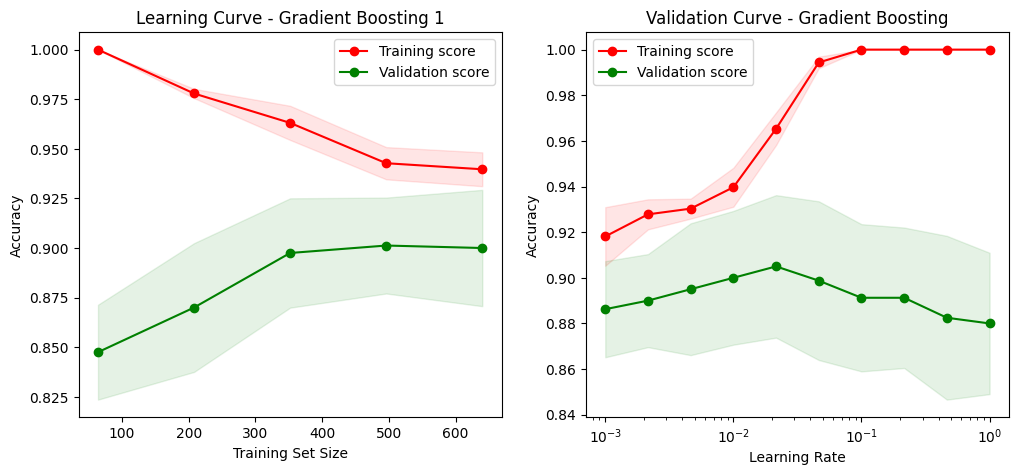

In [68]:
# GradientBoosting Mais simples

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, validation_curve

# Modelo Gradient Boosting
modelo_plot = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 200)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(modelo_plot, X_train, y_train, cv=5, scoring="accuracy")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 5))

# Gráfico da Learning Curve
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting 1")
plt.legend()

# Validation Curve (variação do hiperparâmetro learning_rate)
param_range = np.logspace(-3, 0, 10)
train_scores, val_scores = validation_curve(
    #GradientBoostingClassifier(max_depth=3, n_estimators=200),
    modelo_plot,
    X_train, y_train,
    param_name="learning_rate",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfico da Validation Curve
plt.subplot(1, 2, 2)
plt.semilogx(param_range, train_mean, 'o-', color="r", label="Training score")
plt.semilogx(param_range, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Validation Curve - Gradient Boosting")
plt.legend()

plt.show()

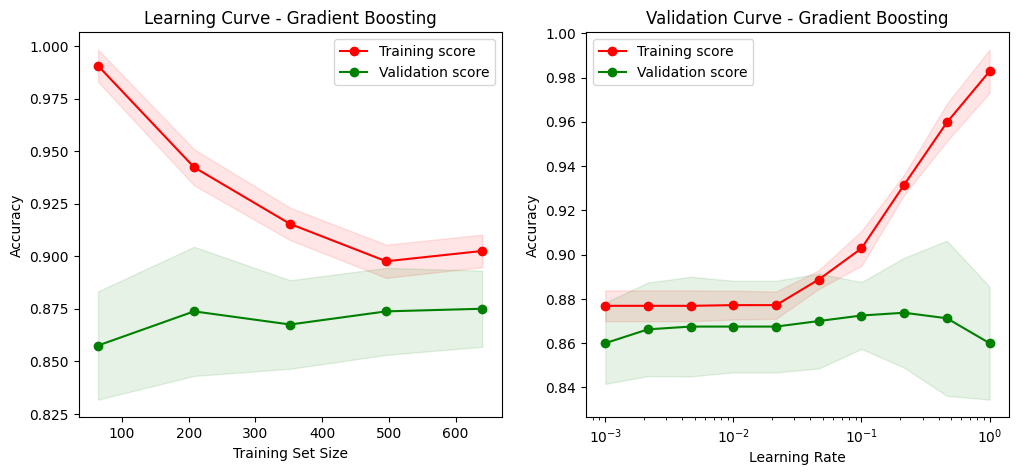

In [67]:
# Modelo Gradient Boosting mais complexo

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve, validation_curve

modelo_plot = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, 
                                         subsample=0.8, min_samples_split=10, min_samples_leaf=5)

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(modelo_plot, X_train, y_train, cv=5, scoring="accuracy")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 5))

# Gráfico da Learning Curve
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()

# Validation Curve (variação do hiperparâmetro learning_rate)
param_range = np.logspace(-3, 0, 10)
train_scores, val_scores = validation_curve(
    # GradientBoostingClassifier(max_depth=3, n_estimators=200),
    modelo_plot,
    X_train, y_train,
    param_name="learning_rate",
    param_range=param_range,
    cv=5,
    scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Gráfico da Validation Curve
plt.subplot(1, 2, 2)
plt.semilogx(param_range, train_mean, 'o-', color="r", label="Training score")
plt.semilogx(param_range, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Validation Curve - Gradient Boosting")
plt.legend()

plt.show()


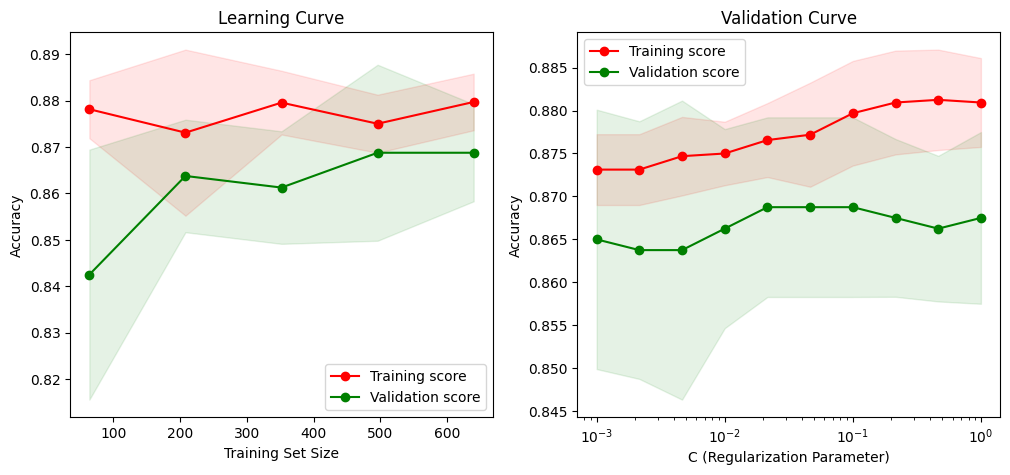

In [65]:
# Regressão Logísitica

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Simulação dos dados (substituir por X_train e y_train reais)
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base
modelo_plot = LogisticRegression(C=0.1, solver='liblinear')

# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(modelo_plot, X_train, y_train, cv=5, scoring="accuracy")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()

# Validation Curve (variação do hiperparâmetro C)
param_range = np.logspace(-3, 0, 10)
train_scores, val_scores = validation_curve(modelo_plot, X_train, y_train, 
                                            param_name="C", param_range=param_range, cv=5, scoring="accuracy")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.subplot(1, 2, 2)
plt.semilogx(param_range, train_mean, 'o-', color="r", label="Training score")
plt.semilogx(param_range, val_mean, 'o-', color="g", label="Validation score")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.title("Validation Curve")
plt.legend()

plt.show()


In [66]:

# Escolhendo um modelo
modelo_final = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, 
                                         subsample=0.8, min_samples_split=10, min_samples_leaf=5)


# Treinar com todos os dados
modelo_final.fit(df, Y)

y_pred = modelo_final.predict_proba(df_submit)
y_pred = 1 - y_pred
df_submission = pd.DataFrame({'Id': df_test['Id'], 'Predicted': y_pred[:, 1]})

df_submission.to_csv(
    os.path.join(FILES_DIRECTORY, 'submissao_noite.csv'),
    sep=',',
    index=False,
    float_format='%.2f'
)